In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback,
    PreTrainedModel,
    PretrainedConfig
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42 #for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/isaacanwar/Desktop/Projects/Classification-RAG-gaurdrail/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# Model Config
MODEL_NAME = "answerdotai/ModernBERT-base"
MAX_LENGTH = 256  # Increased to fit both texts
HIDDEN_DIM = 256
DROPOUT = 0.3

# Embedding dimensions
STAGE_EMBED_DIM = 32

# Training configuration
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 64
LEARNING_RATE = 4e-5
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
PATIENCE = 3  # Early stopping patience

# Label mappings for Layer 2 multi-class classification
id2label = {
    0: "answer_submission",
    1: "inquiry",
    2: "off_topic",
    3: "small_talk"
}
label2id = {v: k for k, v in id2label.items()}
NUM_LABELS = len(id2label)

# Stage mappings (3 stages — challenge merged into technical_depth)
stage2id = {
    "opening": 0,
    "technical_depth": 1,
    "closing": 2
}
id2stage = {v: k for k, v in stage2id.items()}
NUM_STAGES = len(stage2id)

# CLASS WEIGHTS: Moderate boost for minority classes while keeping answer_submission prioritized
CLASS_WEIGHTS_CONFIG = {
    0: 0.7,   # answer_submission (dominant class)
    1: 1.5,   # inquiry (merged clarification_request + process_inquiry)
    2: 2.0,   # off_topic (modest boost)
    3: 1.2    # small_talk (already performing well)
}
CLASS_WEIGHTS = torch.tensor([CLASS_WEIGHTS_CONFIG[i] for i in range(NUM_LABELS)], dtype=torch.float32)

print(f"Classes: {NUM_LABELS} intents, {NUM_STAGES} stages")
print(f"\nClass Weights Applied:")
for i in range(NUM_LABELS):
    print(f"  {id2label[i]:25s}: {CLASS_WEIGHTS_CONFIG[i]:.1f}x")

MODEL_CONFIG = {
    'model_name': MODEL_NAME,
    'num_labels': NUM_LABELS,
    'num_stages': NUM_STAGES,
    'stage_embed_dim': STAGE_EMBED_DIM,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT
}

Classes: 4 intents, 3 stages

Class Weights Applied:
  answer_submission        : 0.7x
  inquiry                  : 1.5x
  off_topic                : 2.0x
  small_talk               : 1.2x


In [3]:
# CSV columns: user_query, prev_agent_response, interview_stage, label
df = pd.read_csv('layer2_contextual_data.csv')

# Clean data
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df = df.dropna(subset=['user_query'])
df['label'] = df['label'].astype(int)
df = df[df['label'].isin([0, 1, 2, 3])].copy()

# Validate stages
df = df[df['interview_stage'].isin(stage2id.keys())].copy()

print(f"Loaded {len(df)} samples")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())
print(f"\nStage distribution:")
print(df['interview_stage'].value_counts())
df.head(5)

Loaded 7440 samples

Label distribution:
label
0    4419
1    1647
2     570
3     804
Name: count, dtype: int64

Stage distribution:
interview_stage
technical_depth    4632
opening            1528
closing            1280
Name: count, dtype: int64


,user_query,prev_agent_response,interview_stage,label
0,I've spent the last five years in quantitative...,Welcome. Please tell me about your background ...,opening,0
1,My experience has largely been with equity der...,That's a strong background. Can you elaborate ...,opening,0
2,I'm proficient in Python and C++ for model imp...,Excellent. What programming languages and tool...,opening,0
3,Could you clarify if you're asking about the t...,Let's start with a foundational concept. Can y...,technical_depth,1
4,The Black-Scholes-Merton model assumes that th...,Could you clarify if you're asking about the t...,technical_depth,0


In [4]:
# First split: 70% train, 30% val/test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=RANDOM_SEED, 
    stratify=df['label']
)

# Second split: 15% val, 15% test (50-50 split of the 30%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=RANDOM_SEED, 
    stratify=temp_df['label']
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size: 5208 (70.0%)
Val size: 1116 (15.0%)
Test size: 1116 (15.0%)


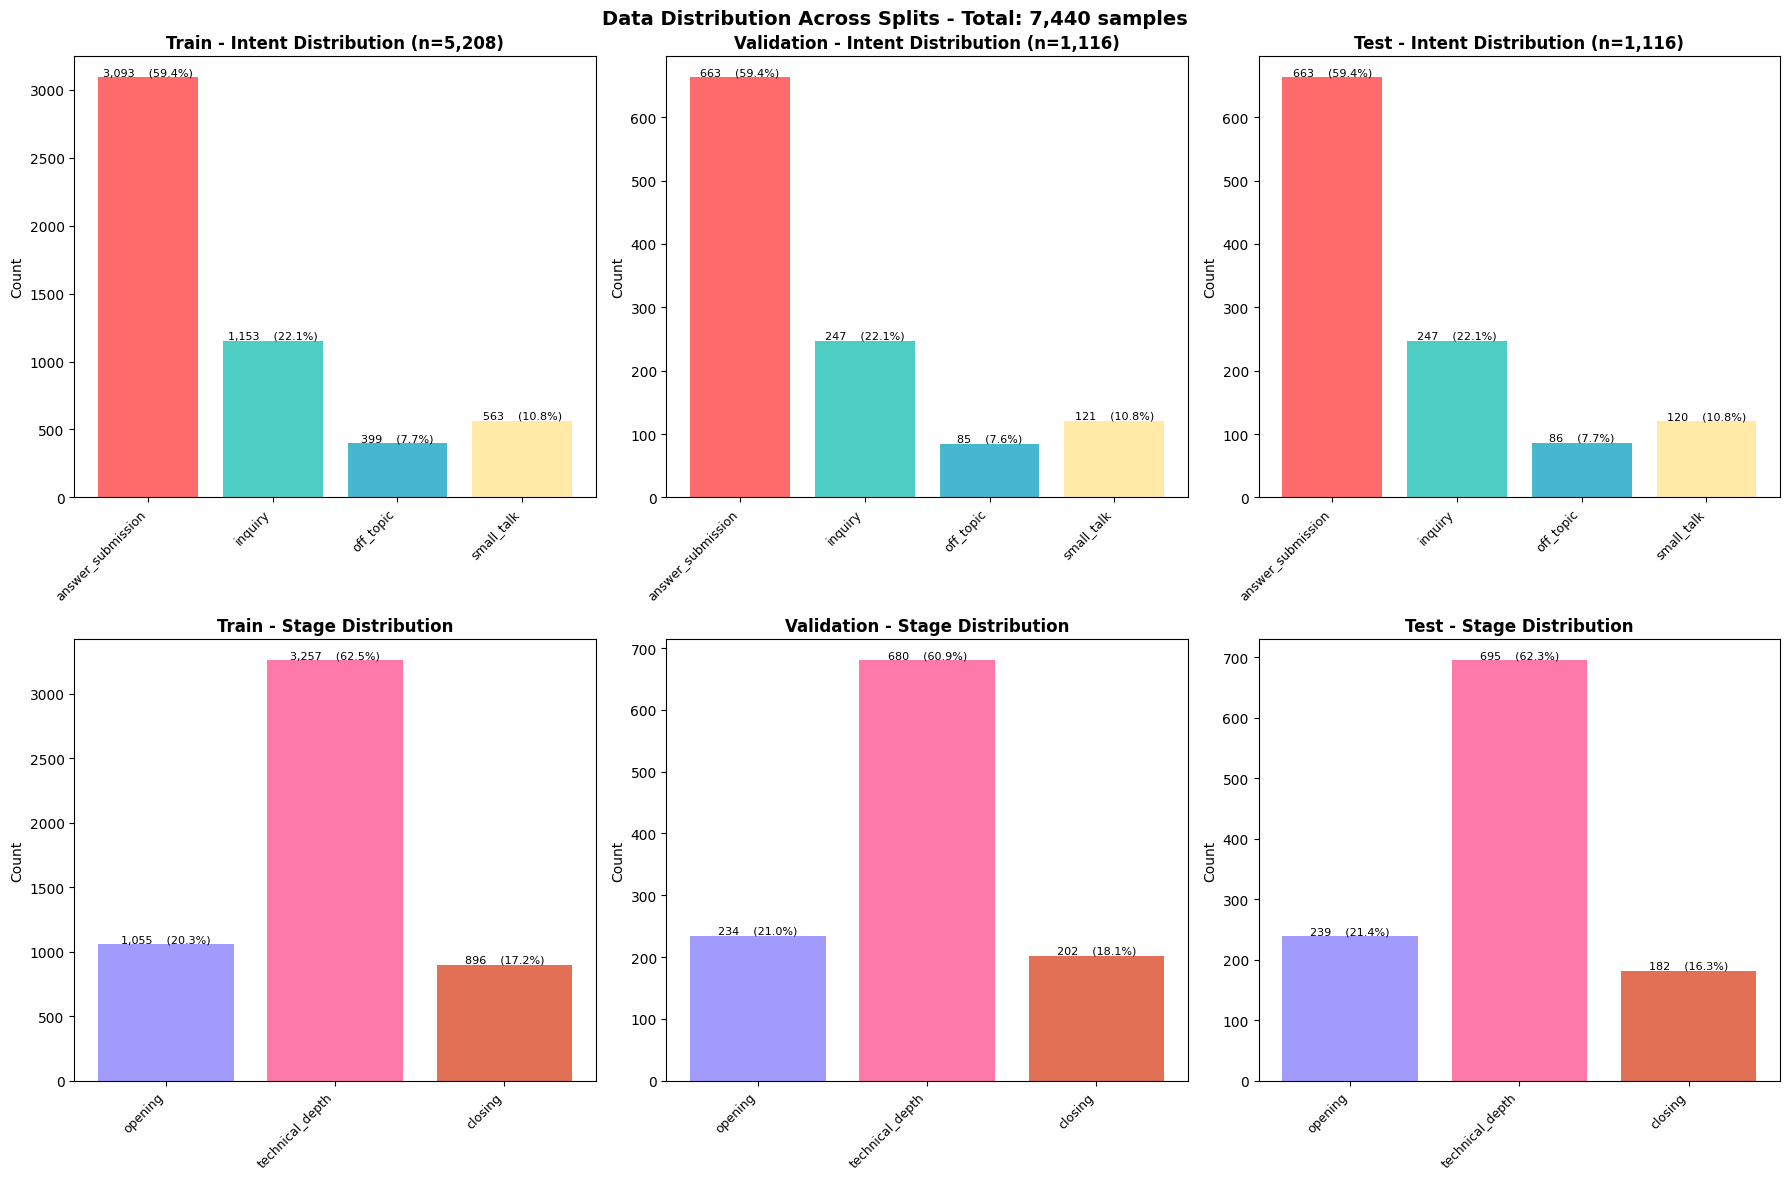

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

colors_intent = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffeaa7']
colors_stage = ['#a29bfe', '#fd79a8', '#e17055']
class_names = [id2label[i] for i in range(NUM_LABELS)]
stage_names = list(stage2id.keys())

# Row 1: Intent distribution
for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['label'].value_counts().sort_index()
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[0, idx].bar(range(NUM_LABELS), counts.values, color=colors_intent)
    axes[0, idx].set_title(f'{split_name} - Intent Distribution (n={len(split_df):,})', fontsize=12, fontweight='bold')
    axes[0, idx].set_ylabel('Count')
    axes[0, idx].set_xticks(range(NUM_LABELS))
    axes[0, idx].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}    ({pct:.1f}%)'
        axes[0, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                          label, ha='center', va='bottom', fontsize=8)

# Row 2: Stage distribution
for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['interview_stage'].value_counts()
    # Reorder to match stage2id
    counts = counts.reindex(stage_names)
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[1, idx].bar(range(NUM_STAGES), counts.values, color=colors_stage)
    axes[1, idx].set_title(f'{split_name} - Stage Distribution', fontsize=12, fontweight='bold')
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].set_xticks(range(NUM_STAGES))
    axes[1, idx].set_xticklabels(stage_names, rotation=45, ha='right', fontsize=9)
    
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}    ({pct:.1f}%)'
        axes[1, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                          label, ha='center', va='bottom', fontsize=8)

plt.suptitle(f'Data Distribution Across Splits - Total: {len(df):,} samples', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
class ContextAwareLayer2Config(PretrainedConfig):
    """Custom config for ContextAwareLayer2Classifier."""
    model_type = "context_aware_layer2"
    
    def __init__(
        self,
        model_name: str = "answerdotai/ModernBERT-base",
        num_labels: int = 4,
        num_stages: int = 3,
        stage_embed_dim: int = 32,
        hidden_dim: int = 256,
        dropout: float = 0.3,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.model_name = model_name
        self.num_labels = num_labels
        self.num_stages = num_stages
        self.stage_embed_dim = stage_embed_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout


class ContextAwareLayer2Classifier(PreTrainedModel):
    """
    Context-aware intent classifier that combines:
    - Text encoding (ModernBERT with [prev_msg] [SEP] [current_query])
    - Interview stage embedding
    
    Compatible with HuggingFace Trainer.
    """
    config_class = ContextAwareLayer2Config
    _no_split_modules = ["bert"]
    _keep_in_fp32_modules = []
    _tied_weights_keys = []
    
    @property
    def all_tied_weights_keys(self):
        """Return empty dict since we don't have tied weights."""
        return {}
    
    @classmethod
    def _can_set_experts_implementation(cls) -> bool:
        return False
    
    def __init__(self, config):
        super().__init__(config)
        
        self.num_labels = config.num_labels
        
        # Check if we're in meta device context (from_pretrained uses this)
        from transformers import AutoConfig
        try:
            test_tensor = torch.empty(0)
            in_meta_context = test_tensor.device.type == "meta"
        except:
            in_meta_context = False
        
        # ModernBERT encoder for text
        if in_meta_context:
            # Loading from checkpoint - use from_config (weights loaded later by from_pretrained)
            bert_config = AutoConfig.from_pretrained(config.model_name)
            self.bert = AutoModel.from_config(bert_config)
        else:
            # Fresh initialization - load pretrained weights
            self.bert = AutoModel.from_pretrained(config.model_name)
        
        self.bert_hidden_size = self.bert.config.hidden_size  # 768
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Stage embedding
        self.stage_embedding = nn.Embedding(
            num_embeddings=config.num_stages,
            embedding_dim=config.stage_embed_dim
        )
        
        # Calculate combined dimension
        combined_dim = self.bert_hidden_size + config.stage_embed_dim
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.num_labels)
        )
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        interview_stage: torch.Tensor,
        labels: torch.Tensor = None,
        **kwargs  # Accept other kwargs from Trainer
    ):
        """
        Forward pass compatible with HuggingFace Trainer.
        
        Args:
            input_ids: Tokenized text [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]
            interview_stage: Stage indices [batch_size]
            labels: Ground truth labels [batch_size] (optional)
        
        Returns:
            dict with 'loss' (if labels provided) and 'logits'
        """
        # 1. Encode text through BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use [CLS] token embedding
        text_embedding = bert_output.last_hidden_state[:, 0, :]  # [batch_size, 768]
        
        # 2. Embed stage
        stage_emb = self.stage_embedding(interview_stage)  # [batch_size, 32]
        
        # 3. Concatenate all embeddings
        combined = torch.cat([text_embedding, stage_emb], dim=-1)  # [batch_size, 800]
        
        # 4. Classification
        logits = self.classifier(combined)  # [batch_size, num_labels]
        
        # 5. Compute loss if labels provided (with class weights)
        loss = None
        if labels is not None:
            # Apply class weights to penalize minority class errors more heavily
            weights = CLASS_WEIGHTS.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=weights)
            loss = loss_fct(logits, labels)
        
        # Return in format expected by Trainer
        return {
            'loss': loss,
            'logits': logits
        }
    
    def count_parameters(self):
        """Count trainable and frozen parameters."""
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen = sum(p.numel() for p in self.parameters() if not p.requires_grad)
        return trainable, frozen

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = ContextAwareLayer2Config(**MODEL_CONFIG)
model = ContextAwareLayer2Classifier(config)

trainable, frozen = model.count_parameters()
print(f"Parameters: {trainable:,} trainable, {frozen:,} frozen")

Loading weights: 100%|██████████| 134/134 [00:00<00:00, 1927.58it/s, Materializing param=layers.21.mlp_norm.weight]    
ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
decoder.bias      | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Parameters: 206,180 trainable, 149,014,272 frozen


In [8]:
def prepare_dataset(df):
    """Prepare dataframe for tokenization."""
    df['combined_text'] = df.apply(
        lambda row: f"{str(row['prev_agent_response']) if pd.notna(row['prev_agent_response']) else ''} {tokenizer.sep_token} {str(row['user_query'])}",
        axis=1
    )
    df['interview_stage'] = df['interview_stage'].map(stage2id)
    return df[['combined_text', 'interview_stage', 'label']].copy()

train_prepared = prepare_dataset(train_df)
val_prepared = prepare_dataset(val_df)
test_prepared = prepare_dataset(test_df)

train_dataset = Dataset.from_pandas(train_prepared.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_prepared.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_prepared.reset_index(drop=True))

def tokenize_function(examples):
    tokenized = tokenizer(
        examples['combined_text'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length'
    )
    tokenized['interview_stage'] = examples['interview_stage']
    tokenized['labels'] = examples['label']
    return tokenized

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text', 'label'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text', 'label'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['combined_text', 'label'])

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'interview_stage', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'interview_stage', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'interview_stage', 'labels'])

print(f"Datasets ready: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

Map: 100%|██████████| 1116/1116 [00:00<00:00, 20392.81 examples/s]

Datasets ready: train=5208, val=1116, test=1116


In [9]:
def compute_metrics_for_trainer(eval_pred):
    """
    Compute metrics for HuggingFace Trainer.
    
    Args:
        eval_pred: EvalPrediction object with predictions and label_ids
    
    Returns:
        Dictionary of metrics
    """
    # Handle both tuple unpacking and object attributes
    if hasattr(eval_pred, 'predictions'):
        predictions = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        predictions, labels = eval_pred
    
    # predictions are logits, convert to probabilities and predicted classes
    import scipy.special
    probs = scipy.special.softmax(predictions, axis=-1)
    preds = np.argmax(predictions, axis=-1)
    
    confidence = np.max(probs, axis=-1)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, labels=list(range(NUM_LABELS)), zero_division=0
    )
    
    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    
    # Per-class AUC
    per_class_auc = []
    for i in range(NUM_LABELS):
        binary_labels = (labels == i).astype(int)
        if binary_labels.sum() > 0 and binary_labels.sum() < len(binary_labels):
            auc = roc_auc_score(binary_labels, probs[:, i])
        else:
            auc = 0.0
        per_class_auc.append(auc)
    
    # Confidence stats
    correct_mask = preds == labels
    
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": macro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_auc": np.mean(per_class_auc),
        "confidence_mean": confidence.mean(),
        "confidence_correct": confidence[correct_mask].mean() if correct_mask.any() else 0.0,
        "confidence_wrong": confidence[~correct_mask].mean() if (~correct_mask).any() else 0.0,
    }
    
    for i, label_name in id2label.items():
        metrics[f"f1_{label_name}"] = f1[i]
        metrics[f"precision_{label_name}"] = precision[i]
        metrics[f"recall_{label_name}"] = recall[i]
        metrics[f"auc_{label_name}"] = per_class_auc[i]
    
    return metrics

In [10]:
def evaluate_with_stages(model, dataset, df_original, batch_size=64):
    """
    Evaluate model with stage-stratified metrics.
    """
    model.eval()
    eval_device = next(model.parameters()).device

    all_logits = []
    all_labels = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        input_ids      = torch.tensor(batch['input_ids']).to(eval_device)
        attention_mask = torch.tensor(batch['attention_mask']).to(eval_device)
        interview_stage = torch.tensor(batch['interview_stage']).to(eval_device)
        labels_batch   = batch['labels']

        with torch.no_grad():
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            interview_stage=interview_stage)
        all_logits.append(outputs['logits'].cpu().numpy())
        all_labels.extend(labels_batch if isinstance(labels_batch, list) else labels_batch.tolist())

    import scipy.special
    logits = np.concatenate(all_logits, axis=0)
    labels = np.array(all_labels)
    probs  = scipy.special.softmax(logits, axis=-1)
    preds  = np.argmax(logits, axis=-1)

    # Reuse compute_metrics_for_trainer via a lightweight wrapper
    class _FakePred:
        def __init__(self, predictions, label_ids):
            self.predictions = predictions
            self.label_ids   = label_ids

    metrics = compute_metrics_for_trainer(_FakePred(logits, labels))

    # Read stage IDs directly from dataset — always integers, always aligned with predictions
    stage_ids = np.array(dataset['interview_stage'])
    stage_col = np.array([id2stage[int(s)] for s in stage_ids])

    for stage_name in stage2id.keys():
        stage_mask = stage_col == stage_name
        if stage_mask.sum() > 0:
            stage_acc = accuracy_score(labels[stage_mask], preds[stage_mask])
            metrics[f"accuracy_stage_{stage_name}"] = stage_acc
            metrics[f"n_stage_{stage_name}"] = int(stage_mask.sum())
        else:
            metrics[f"accuracy_stage_{stage_name}"] = 0.0
            metrics[f"n_stage_{stage_name}"] = 0

    return metrics, labels, preds, probs


In [11]:
training_args = TrainingArguments(
    output_dir="./layer2_contextual_model",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO, #make sure this is warmup-steps
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_strategy="epoch",  # Changed: log train loss per epoch (same as validation)
    report_to=[],
    save_total_limit=None,
    seed=RANDOM_SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_for_trainer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

print(f"Training: {NUM_EPOCHS} epochs, batch_size={BATCH_SIZE}, lr={LEARNING_RATE}, early_stop={PATIENCE}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Training: 10 epochs, batch_size=32, lr=4e-05, early_stop=3


In [12]:
train_result = trainer.train()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_macro_f1': []}
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        history['train_loss'].append(log['loss'])
    if 'eval_loss' in log:
        history['val_loss'].append(log['eval_loss'])
    if 'eval_accuracy' in log:
        history['val_accuracy'].append(log['eval_accuracy'])
    if 'eval_macro_f1' in log:
        history['val_macro_f1'].append(log['eval_macro_f1'])

best_val_f1 = max(history['val_macro_f1']) if history['val_macro_f1'] else 0.0

trainer.save_model(training_args.output_dir)
tokenizer.save_pretrained(training_args.output_dir)

import json
with open(f"{training_args.output_dir}/label_mappings.json", "w") as f:
    json.dump({
        'id2label': id2label,
        'label2id': label2id,
        'id2stage': id2stage,
        'stage2id': stage2id
    }, f, indent=2)

print(f"Training complete. Best F1: {best_val_f1:.4f}. Saved to {training_args.output_dir}")

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Macro Auc,Confidence Mean,Confidence Correct,Confidence Wrong,F1 Answer Submission,Precision Answer Submission,Recall Answer Submission,Auc Answer Submission,F1 Inquiry,Precision Inquiry,Recall Inquiry,Auc Inquiry,F1 Off Topic,Precision Off Topic,Recall Off Topic,Auc Off Topic,F1 Small Talk,Precision Small Talk,Recall Small Talk,Auc Small Talk
1,1.261127,1.027368,0.736559,0.499778,0.580145,0.486708,0.912539,0.452512,0.471177,0.400324,0.866251,0.801282,0.942685,0.918289,0.556391,0.519298,0.599190,0.844043,0.000000,0.000000,0.000000,0.891710,0.576471,1.000000,0.404959,0.996113
2,0.885956,0.761926,0.795699,0.686962,0.792826,0.647897,0.938447,0.575112,0.605141,0.458158,0.891794,0.859944,0.926094,0.948025,0.615970,0.580645,0.655870,0.892365,0.413793,0.774194,0.282353,0.917019,0.826291,0.956522,0.727273,0.996379
3,0.703179,0.635385,0.830645,0.759166,0.817429,0.723769,0.952850,0.651071,0.682076,0.499002,0.909492,0.887931,0.932127,0.963648,0.678295,0.650558,0.708502,0.924675,0.608696,0.792453,0.494118,0.926342,0.840183,0.938776,0.760331,0.996736
4,0.607373,0.561963,0.844982,0.781640,0.813476,0.758892,0.961497,0.688650,0.722295,0.505255,0.915860,0.904412,0.927602,0.970833,0.710938,0.686792,0.736842,0.945626,0.635135,0.746032,0.552941,0.932595,0.864629,0.916667,0.818182,0.996935
5,0.541537,0.515699,0.867384,0.811930,0.827526,0.802211,0.966742,0.715982,0.746357,0.517309,0.927492,0.928896,0.926094,0.974392,0.756335,0.729323,0.785425,0.958936,0.662252,0.757576,0.588235,0.936487,0.901639,0.894309,0.909091,0.997151
6,0.507292,0.482747,0.875448,0.829945,0.844596,0.817814,0.969294,0.745516,0.775946,0.531632,0.928358,0.918759,0.938160,0.976566,0.765182,0.765182,0.765182,0.962365,0.713376,0.777778,0.658824,0.940811,0.912863,0.916667,0.909091,0.997433
7,0.471786,0.459841,0.887097,0.844677,0.854240,0.836938,0.971834,0.755598,0.783253,0.538305,0.935338,0.932534,0.938160,0.978331,0.792000,0.782609,0.801619,0.968082,0.729560,0.783784,0.682353,0.943333,0.921811,0.918033,0.925620,0.997591
8,0.454007,0.445719,0.888889,0.846281,0.852316,0.841526,0.973305,0.762050,0.790117,0.537516,0.937358,0.938066,0.936652,0.979407,0.796813,0.784314,0.809717,0.971543,0.732919,0.776316,0.694118,0.944611,0.918033,0.910569,0.925620,0.997658
9,0.443271,0.437111,0.890681,0.850177,0.855889,0.845480,0.974074,0.767899,0.796002,0.538929,0.937358,0.938066,0.936652,0.980059,0.800797,0.788235,0.813765,0.972741,0.740741,0.779221,0.705882,0.945798,0.921811,0.918033,0.925620,0.997699
10,0.435276,0.434410,0.892473,0.851721,0.857011,0.847504,0.974370,0.768718,0.796279,0.539966,0.938776,0.940909,0.936652,0.980329,0.805556,0.789883,0.821862,0.973230,0.740741,0.779221,0.705882,0.946163,0.921811,0.918033,0.925620,0.997757


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

Training complete. Best F1: 0.8517. Saved to ./layer2_contextual_model


In [13]:
import os
import json

model_dir = "./layer2_contextual_model/checkpoint-1467"
mappings_dir = "./layer2_contextual_model"  # Parent directory where label_mappings.json is saved

with open(os.path.join(mappings_dir, 'label_mappings.json'), 'r') as f:
    mappings = json.load(f)
    id2label = {int(k): v for k, v in mappings['id2label'].items()}
    label2id = mappings['label2id']
    id2stage = {int(k): v for k, v in mappings['id2stage'].items()}
    stage2id = mappings['stage2id']

# Fix for MPS device: Load to CPU first, then move to device
model = ContextAwareLayer2Classifier.from_pretrained(model_dir)

# Explicitly move all submodules to device (important for MPS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Extra step for MPS: ensure BERT encoder is on correct device
if hasattr(model, 'bert'):
    model.bert = model.bert.to(device)
if hasattr(model, 'stage_embedding'):
    model.stage_embedding = model.stage_embedding.to(device)
if hasattr(model, 'classifier'):
    model.classifier = model.classifier.to(device)

model.eval()

# Load tokenizer from parent directory (where it was saved during training)
tokenizer = AutoTokenizer.from_pretrained(mappings_dir)
print(f"Model loaded from {model_dir}")
print(f"Tokenizer loaded from {mappings_dir}")
print(f"Device: {device}")

Loading weights: 100%|██████████| 139/139 [00:00<00:00, 2206.43it/s, Materializing param=stage_embedding.weight]             
You are using a model of type context_aware_layer2 to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Model loaded from ./layer2_contextual_model/checkpoint-1467
Tokenizer loaded from ./layer2_contextual_model
Device: cpu


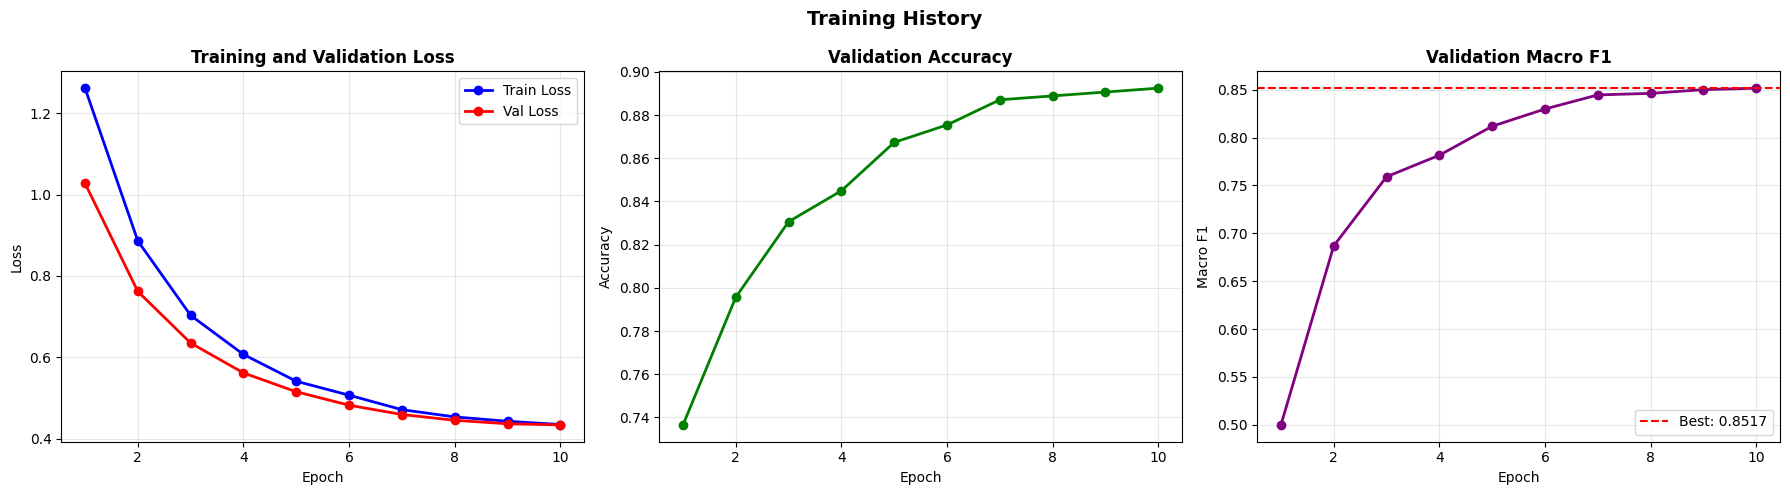

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['val_loss']) + 1)

# Loss - both logged per epoch now
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['val_accuracy'], 'g-', linewidth=2, marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Macro F1
axes[2].plot(epochs_range, history['val_macro_f1'], 'purple', linewidth=2, marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Validation Macro F1', fontweight='bold')
axes[2].axhline(y=best_val_f1, color='red', linestyle='--', label=f'Best: {best_val_f1:.4f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
test_metrics, test_labels, test_preds, test_probs = evaluate_with_stages(
    model, test_dataset, test_df, batch_size=EVAL_BATCH_SIZE
)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Macro F1: {test_metrics['macro_f1']:.4f}")
print(f"  Macro Precision: {test_metrics['macro_precision']:.4f}")
print(f"  Macro Recall: {test_metrics['macro_recall']:.4f}")
print(f"  Macro AUC: {test_metrics['macro_auc']:.4f}")

print(f"\nConfidence Statistics:")
print(f"  Mean Confidence: {test_metrics['confidence_mean']:.4f}")
print(f"  Confidence (Correct): {test_metrics['confidence_correct']:.4f}")
print(f"  Confidence (Wrong): {test_metrics['confidence_wrong']:.4f}")

print(f"\nStratified by Stage:")
for stage_name in stage2id.keys():
    acc = test_metrics[f'accuracy_stage_{stage_name}']
    n = test_metrics[f'n_stage_{stage_name}']
    print(f"  {stage_name}: {acc:.4f} (n={n})")

TEST SET RESULTS

Overall Metrics:
  Accuracy: 0.9023
  Macro F1: 0.8551
  Macro Precision: 0.8803
  Macro Recall: 0.8353
  Macro AUC: 0.9815

Confidence Statistics:
  Mean Confidence: 0.7679
  Confidence (Correct): 0.7929
  Confidence (Wrong): 0.5365

Stratified by Stage:
  opening: 0.8285 (n=239)
  technical_depth: 0.9309 (n=695)
  closing: 0.8901 (n=182)


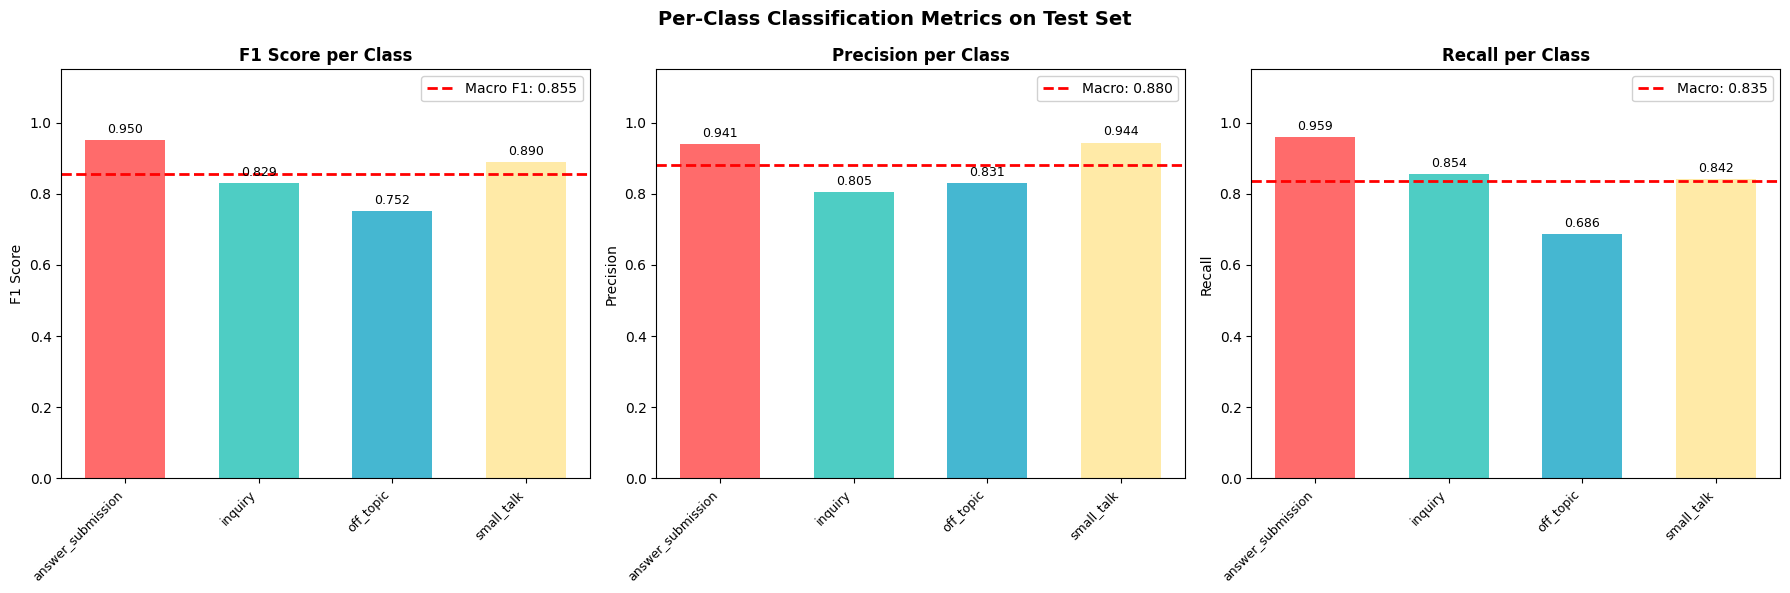

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_names = [id2label[i] for i in range(NUM_LABELS)]
x = np.arange(NUM_LABELS)
bar_width = 0.6
colors_intent = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffeaa7']

# F1 Scores
f1_scores = [test_metrics[f"f1_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[0].bar(x, f1_scores, bar_width, color=colors_intent)
axes[0].set_title('F1 Score per Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(y=test_metrics["macro_f1"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro F1: {test_metrics["macro_f1"]:.3f}')
axes[0].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, f1_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Precision Scores
precision_scores = [test_metrics[f"precision_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[1].bar(x, precision_scores, bar_width, color=colors_intent)
axes[1].set_title('Precision per Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[1].set_ylim(0, 1.15)
axes[1].axhline(y=test_metrics["macro_precision"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro: {test_metrics["macro_precision"]:.3f}')
axes[1].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, precision_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Recall Scores
recall_scores = [test_metrics[f"recall_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[2].bar(x, recall_scores, bar_width, color=colors_intent)
axes[2].set_title('Recall per Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Recall')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[2].set_ylim(0, 1.15)
axes[2].axhline(y=test_metrics["macro_recall"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro: {test_metrics["macro_recall"]:.3f}')
axes[2].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, recall_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

plt.suptitle('Per-Class Classification Metrics on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

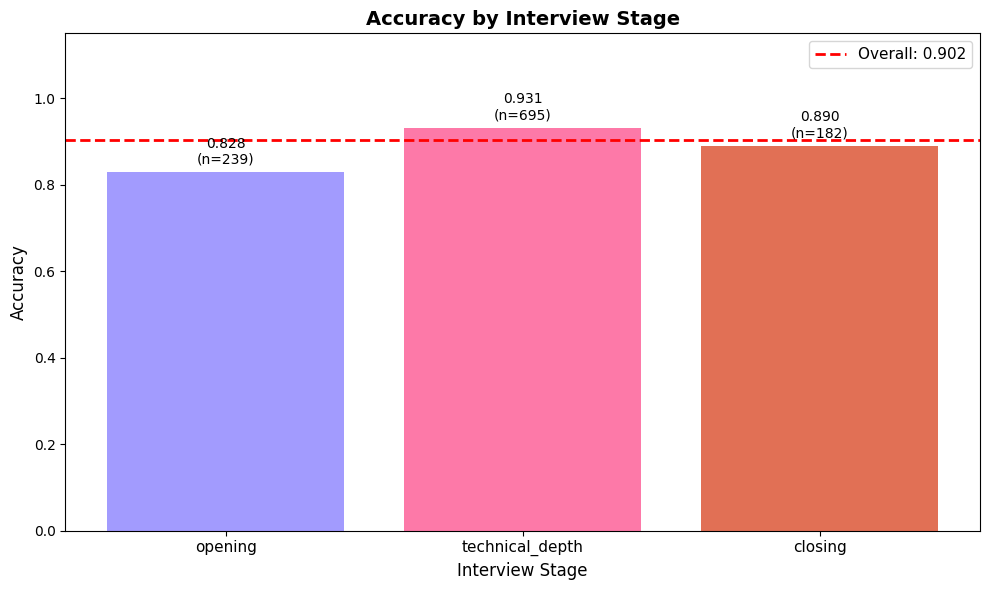

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy by Interview Stage
stage_names = list(stage2id.keys())
stage_accs = [test_metrics[f'accuracy_stage_{s}'] for s in stage_names]
stage_counts = [test_metrics[f'n_stage_{s}'] for s in stage_names]
colors_stage = ['#a29bfe', '#fd79a8', '#e17055']

bars = ax.bar(range(len(stage_names)), stage_accs, color=colors_stage)
ax.set_title('Accuracy by Interview Stage', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Interview Stage', fontsize=12)
ax.set_xticks(range(len(stage_names)))
ax.set_xticklabels(stage_names, fontsize=11)
ax.set_ylim(0, 1.15)
ax.axhline(y=test_metrics['accuracy'], color='red', linestyle='--', linewidth=2,
           label=f'Overall: {test_metrics["accuracy"]:.3f}')
ax.legend(loc='upper right', fontsize=11)

for bar, acc, count in zip(bars, stage_accs, stage_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{acc:.3f}\n(n={count})', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

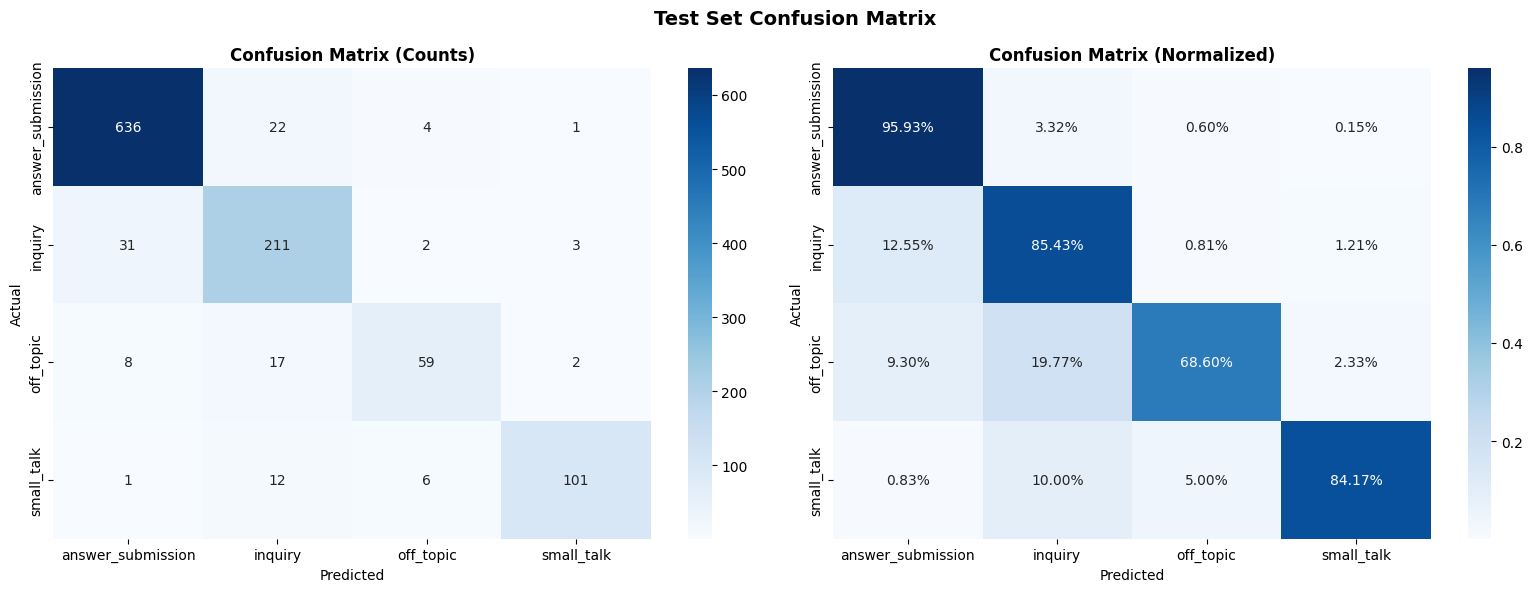

In [18]:
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_names = [id2label[i] for i in range(NUM_LABELS)]

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')

plt.suptitle('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Updated predict function with proper device handling for MPS
def predict_fixed(
    model,
    tokenizer,
    user_query: str,
    prev_agent_response: str = "",
    interview_stage: str = "opening",
    confidence_threshold: float = 0.5
):
    """
    Make a prediction with context - MPS device compatible.
    """
    model.eval()
    
    # Get device from model (important for MPS)
    device = next(model.parameters()).device
    
    combined_text = f"{prev_agent_response} {tokenizer.sep_token} {user_query}"
    encoding = tokenizer(
        combined_text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    stage_tensor = torch.tensor([stage2id[interview_stage]], dtype=torch.long).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, stage_tensor)
        logits = outputs['logits']
        probs = torch.softmax(logits, dim=-1)[0]
    
    pred_class = probs.argmax().item()
    confidence = probs[pred_class].item()
    pred_label = id2label[pred_class]
    
    if confidence >= confidence_threshold:
        status = f"ACCEPTED - {pred_label}"
    else:
        status = f"FLAGGED (low confidence) - Predicted: {pred_label}"
    
    return {
        'prediction': pred_label,
        'prediction_id': pred_class,
        'confidence': confidence,
        'status': status,
        'all_probs': {id2label[i]: probs[i].item() for i in range(NUM_LABELS)}
    }

# Use this function instead of predict()
predict = predict_fixed

In [21]:
test_query = "My most challenging project involved the modeling of EBITA as a time series."
test_prev_response = "Tell me about your most challenging technical project."
test_stage = "technical_depth"

result = predict(
    model=model,
    tokenizer=tokenizer,
    user_query=test_query,
    prev_agent_response=test_prev_response,
    interview_stage=test_stage
)

print("="*60)
print("PREDICTION ANALYSIS")
print("="*60)
print(f"\nInput:")
print(f"  Query: '{test_query}'")
print(f"  Prev Response: '{test_prev_response}'")
print(f"  Stage: {test_stage}")
print(f"\nPrediction: {result['prediction']} (label {label2id[result['prediction']]})")
print(f"Confidence: {result['confidence']:.1%}")
print(f"Status: {result['status']}")
print("\nTop 3 Predictions:")
sorted_probs = sorted(result['all_probs'].items(), key=lambda x: -x[1])
for i, (label, prob) in enumerate(sorted_probs[:3], 1):
    marker = " <- PREDICTED" if label == result['prediction'] else ""
    print(f"  {i}. {label:25s} {prob:6.1%}{marker}")


PREDICTION ANALYSIS

Input:
  Query: 'My most challenging project involved the modeling of EBITA as a time series.'
  Prev Response: 'Tell me about your most challenging technical project.'
  Stage: technical_depth

Prediction: answer_submission (label 0)
Confidence: 46.6%
Status: FLAGGED (low confidence) - Predicted: answer_submission

Top 3 Predictions:
  1. answer_submission          46.6% <- PREDICTED
  2. inquiry                    35.2%
  3. off_topic                  16.5%
